# Evaluating machine learning model performance

## Introduction

Use of machine learning in the quantitative investment field is, by all indications, skyrocketing.  The proliferation of easily accessible data - both traditional and alternative - along with some very approachable frameworks for machine learning models - is encouraging many to explore the arena.

These financial ML explorers are learning that there are many ways in which using ML to predict financial time series differs greatly from labeling cat pictures or flagging spam.  Application of machine learning to financial time series prediction is made especially difficult due to (1) non-stationarity, (2) low signal-to-noise, and (3) strong feature collinearity within financial data. [link to post on the challenges of ML in finance]    

As a consequence, even the most expertly designed ML models will achieve accuracy levels which would seem wholly inadequate in other domains.  It's hard to get excited about an RSQ of 0.10 or a classification accuracy of 0.60, but that is often the reality.    

In my view, the generic model performance metrics (RSQ, MSE, accuracy, F1, etc...) are not tremendously useful when working in this sort of problem space.  Similarly, the traditional quantitative finance metrics (CAGR, sharpe, maxDD, etc...) do not provide as much insight into the models themselves as they do into the particular time period of data used.   

Over the years, I've developed a set of metrics which have proved useful for comparing and optimizing models.  These metrics attempt to measure model performance in terms of _predictive power_ but also in terms of _practicality_, a critically important dimension for those who actually intend to _use_ their models in the real world.    

In this post, I will present a general outline of my approach and will demonstrate a few of the most useful metrics I've added to my standard "scorecard".  I look forward to hearing how others may think to extend the concept.  

## Key Metrics
Before presenting the step-by-step mechanics of calculating these metrics, let me give a few examples of the more useful metrics of this sort.

* __Accuracy:__ Just as the name suggests, this measures the percent of predictions that were _directionally_ correct vs. incorrect.
* __Edge:__ perhaps the most useful of all metrics, this is the expected value of the prediction over a sufficiently large set of draws.  Think of this like a blackjack card counter who knows the expected profit on each dollar bet when the odds are at a level of favorability
* __Noise:__ critically important but often ignored, the noise metric estimates how dramatically the model's predictions vary from one day to the next.  As you might imagine, a model which abruptly changes its mind every few days is much harder to follow (and much more expensive to follow) than one which is a bit more steady.    

These metrics can be combined and adapted in many different ways, some of which I'll lay out in the below example.  





I will illustrate the usefulness of this metrics methodology using a simple example of generated data.  First we generate the data using a thin wrapper around one of scikit-learn's random data generator method.  We'll create a set of 5 features in X which contain signal buried in considerable noise.  

Note that for simplicity, this simply creates daily data points including weekends and holidays - clearly not realistic but fine for this toy example.

In [1]:
from sklearn.datasets import make_regression
import pandas as pd
import numpy as np

def make_data_regression(begin_date='2014-01-01',end_date='2017-12-31',\
                         num_features=15,num_informative=2,\
                         noise=5.0,bias=0.1,effective_rank=2,random=42):
    dates = pd.date_range(start=begin_date, end=end_date)
    X_vals, y_vals = make_regression(n_samples=len(dates), n_features=num_features, \
                                     n_informative=num_informative, bias=0.1, noise=2.0,\
                                     tail_strength =0.5,effective_rank=effective_rank,random_state=random)
    X = pd.DataFrame(X_vals, index=dates)*0.5
    y = pd.Series(y_vals, index=dates)*0.5
    y.name = 'y_true'
    X.columns = ['f_' + str(i) for i in range(num_features)]
    return X,y

X,y = make_data_regression()

Next, we'll split this X (pd.DataFrame) and y (pd.Series) into train and test sets.  Note that I prefer to split sequentially rather than randomly (i.e., shuffle=False) since this is a better simulation of the stationarity (or lack thereof) of the data.  


In [2]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,shuffle=False)

Then we will specify and predict a very simple linear model in scikit-learn so we have some predictions to compare with ground truth.

In [3]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train,y_train)
print("RSQ of: "+str(reg.score(X_train,y_train)))
pred_vals = reg.predict(X_train)
y_pred = pd.Series(pred_vals,index=y_train.index)
y_pred.name = 'y_pred'

RSQ of: 0.08218499608401153


Let's visualize the datasets

### Visualizing the dataset
From visual inspection, this data seems like a good approximation of a stock price prediction problem.  There is clearly signal picked up by the model (clear upward sloping "cloud" of data points) but there is plenty of noise in the dataset.  

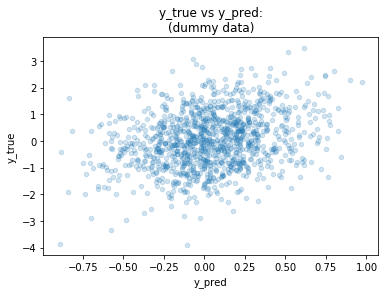

In [4]:
from pandas.plotting import scatter_matrix
%matplotlib inline

df = pd.concat([y_pred,y_train],axis=1)
df.plot.scatter(x='y_pred',y='y_true',alpha=0.2,\
                  title='y_true vs y_pred:\n(dummy data)')

### Creating a scorecard
The first step to efficiently computing the sorts of metrics we'll use is to create a few intermediate values.  It'll become clear why doing this initially will save considerable time later when calculating aggregate metrics.

To create these intermediate values, you'll need the following inputs:
* __y_pred:__ the _continuous variable_ prediction made by your model for each timestep, for each symbol
* __y_true:__ the actual _future_ outcome for each timestep, for each symbol.  
* __index:__ this is the unique identifier for each prediction or actual result.  If working with a single instrument, then you can simply use date (or time or whatever).  If you're using multiple instruments, a multi-index with (date/symbol) is necessary. 

In other words, if your model is predicting one-day price changes, you'd want your y_pred to be the model's predictions made as of March 9th (for the coming day), indexed as `2017-03-09` and you'd want the actual _future_ outcome which will play out in the next day also aligned to Mar 9th.  This "peeking" convention is very useful for working with large sets of data across different time horizons.  I'll describe further in a different post.  

The input data may look like this:

In [6]:
df.tail()

,y_pred,y_true
2017-03-09,0.106969,1.254951
2017-03-10,0.239733,0.622984
2017-03-11,0.094187,-0.228016
2017-03-12,-0.492038,-0.255775
2017-03-13,0.022901,-2.032382


With those two columns, we'll calculate the several "intermediate values" which will make aggregated metrics quick to compute in a vectorized way.  Create a dataframe which contains the following values, using the below function:

* __sign_pred:__ positive or negative sign of prediction
* __sign_true:__ positive or negative sign of true outcome
* __is_correct:__ 1 if sign_pred == sign_true, else 0
* __is_incorrect:__ opposite
* __is_predicted:__ 1 if the model has made a valid prediction, 0 if not.  This is important if models only emit predictions when they have a certain level of confidence
* __result:__ the profit (loss) resulting from betting one unit in the direction of the sign_pred.  This is the continuous variable result of following the model

In [7]:
def make_df(y_pred,y_true):
    y_pred.name = 'y_pred'
    y_true.name = 'y_true'
    
    df = pd.concat([y_pred,y_true],axis=1)

    df['sign_pred'] = df.y_pred.apply(np.sign)
    df['sign_true'] = df.y_true.apply(np.sign)
    df['is_correct'] = 0
    df.loc[df.sign_pred * df.sign_true > 0 ,'is_correct'] = 1 # only registers 1 when prediction was made AND it was correct
    df['is_incorrect'] = 0
    df.loc[df.sign_pred * df.sign_true < 0,'is_incorrect'] = 1 # only registers 1 when prediction was made AND it was wrong
    df['is_predicted'] = df.is_correct + df.is_incorrect
    df['result'] = df.sign_pred * df.y_true
    return df

df = make_df(y_pred,y_train)
df.head()

,y_pred,y_true,sign_pred,sign_true,is_correct,is_incorrect,is_predicted,result
2014-01-01,-0.134808,-0.626610,-1.0,-1.0,1,0,1,0.626610
2014-01-02,-0.314305,0.962966,-1.0,1.0,0,1,1,-0.962966
2014-01-03,-0.028986,-0.756983,-1.0,-1.0,1,0,1,0.756983
2014-01-04,0.074445,0.389084,1.0,1.0,1,0,1,0.389084
2014-01-05,0.287679,0.015818,1.0,1.0,1,0,1,0.015818


With this set of intermediate variables already calculated, we can easily calculate the three core metrics of accuracy, edge, and noise.  We can now easily calculate many derived metrics.  The below function shows several examples, including:
* __y_true_chg__ and __y_pred_chg:__ ...
* __capture_ratio:__ ...
* __prediction_calibration:__ ...

Additionally, metrics can be easily calculated for only long or short predictions (for a two-sided model) or separately for positions which ended up being winners and losers.

* __edge_long__ and __edge_short:__ ...
* __edge_win__ and __edge_lose:__ ...



In [8]:
def calc_scorecard(df):
    scorecard = pd.Series()
    # building block metrics
    scorecard.loc['accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scorecard.loc['edge'] = df.result.mean()
    scorecard.loc['noise'] = df.y_pred.diff().abs().mean()

    scorecard.loc['y_true_chg'] = df.y_true.abs().mean()
    scorecard.loc['y_pred_chg'] = df.y_pred.abs().mean()

    # derived metrics
    scorecard.loc['capture_ratio'] = scorecard.loc['edge']/scorecard.loc['y_true_chg']*100
    scorecard.loc['prediction_calibration'] = scorecard.loc['y_pred_chg']/scorecard.loc['y_true_chg']

    # metrics for a subset of predictions
    scorecard.loc['edge_long'] = df[df.sign_pred == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_short'] = df[df.sign_pred == -1].result.mean()  - df.y_true.mean()

    scorecard.loc['edge_win'] = df[df.is_correct == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_lose'] = df[df.is_incorrect == 1].result.mean()  - df.y_true.mean()

    return scorecard    

calc_scorecard(df)

accuracy                  58.476027
edge                       0.216432
noise                      0.341603
y_true_chg                 0.843239
y_pred_chg                 0.239323
capture_ratio             25.666711
prediction_calibration     0.283814
edge_long                  0.196195
edge_short                 0.162660
edge_win                   0.870532
edge_lose                 -0.790294
dtype: float64

From this (dummy) example, we'd see that the model is predicting with a directional accuracy of almost 65% (!!!) and that we'd expect a statistical edge of 0.36% per period.  

One useful way to put this into context is that our statistical edge is "capturing" greater than 25% of the total available movement in the true outcome (a perfect predictor would have a `capture_ratio` of 100%).

Next, let's apply this simple technique to see how we can compare a couple of different model variations, or compare in sample to out of sample performance.

In [294]:
from sklearn.linear_model import ElasticNetCV,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor

# linear regression
model1 = LinearRegression().fit(X_train,y_train)
model1_train = pd.Series(model1.predict(X_train),index=X_train.index)
model1_test = pd.Series(model1.predict(X_test),index=X_test.index)

model2 = RandomForestRegressor().fit(X_train,y_train)
model2_train = pd.Series(model2.predict(X_train),index=X_train.index)
model2_test = pd.Series(model2.predict(X_test),index=X_test.index)

# create dataframes for each 
model1_train_df = make_df(model1_train,y_train)
model1_test_df = make_df(model1_test,y_test)
model2_train_df = make_df(model2_train,y_train)
model2_test_df = make_df(model2_test,y_test)

s1 = calc_scorecard(model1_train_df)
s1.name = 'model1_train'
s2 = calc_scorecard(model1_test_df)
s2.name = 'model1_test'
s3 = calc_scorecard(model2_train_df)
s3.name = 'model2_train'
s4 = calc_scorecard(model2_test_df)
s4.name = 'model2_test'

pd.concat([s1,s2,s3,s4],axis=1)

,model1_train,model1_test,model2_train,model2_test
accuracy,58.476027,56.313993,88.270548,55.631399
edge,0.216432,0.182502,0.781048,0.163068
noise,0.341603,0.331758,0.832703,0.524860
y_true_chg,0.843239,0.795180,0.843239,0.795180
y_pred_chg,0.239323,0.239982,0.586300,0.372409
capture_ratio,25.666711,22.951002,92.624735,20.507079
prediction_calibration,0.283814,0.301796,0.695295,0.468333
edge_long,0.196195,0.182930,0.768654,0.152970
edge_short,0.162660,0.296730,0.721636,0.304214
edge_win,0.870532,0.925585,0.884521,0.918770


This quick and dirty scorecard comparison gives us a great deal of useful information.  We learn that:
* The relatively simple linear regression (model1) does a reasonable job of prediction, capturing about 28% of available price movement (this is very good)
* Model1 holds up very well out of sample, performing almost identically on test as train
* Model2, a more complex random forest ensemble model, appears _far_ superior on the training data, capturing 92% of available price action, but appears quite overfit and does not perform nearly as well on the test set.

## Next Steps
This simple example demonstrates the basic framework for using a multi-dimensional scorecard to evaluate a model and to compare various models.  However, the approach can be extended much further.  You can consider:
* Adding metrics to the standard scorecard
* Implementing at a portfolio level (i.e., running the same signal across a universe of securities)
* Comparing scorecard metrics for  subsets of the universe.  For instance, if you're testing a model on a multi-symbol universe, you can calculate the scorecard of metrics for each symbol or group of symbols.  You can alternatively calculate the scorecards for periods of time (months, quarters, years, etc...) quite easily.  It's critical to know if your 60% accurate model was actually 75% accurate in the early months and 45% accurate in more recent months!




In [202]:
# live example: momentum in munis
import pandas_datareader.data as web
mub = web.DataReader('MUB', 'iex',start='2014-01-01')['close']

5y


In [261]:
df = pd.DataFrame({'price':mub})
df['pct_chg'] = df.price.pct_change()
df['ema5'] = df.price.ewm(span=5).mean()
df['ema10'] = df.price.ewm(span=10).mean()
df['ema20'] = df.price.ewm(span=20).mean()
df['rel5'] = df.price/df.ema5-1
df['rel10'] = df.price/df.ema10-1
df['rel20'] = df.price/df.ema20-1

X = df[['pct_chg','rel5','rel10','rel20']].dropna()
y_true = df.pct_chg.shift(-5).dropna()
y_true.name = 'y_true'

Xy = X.join(y_true).dropna()
X = Xy.iloc[:,:-1]
y_true = Xy.iloc[:,-1]

In [264]:
reg = Ridge()
reg.fit(X,y_true)
print(reg.score(X,y_true))
y_pred = pd.Series(reg.predict(X),index=y_true.index)

9.197285948170375e-06


In [265]:
df = make_df(y_pred,y_true)
calc_scorecard(df)


accuracy                  5.517891e+01
edge                      1.324263e-04
noise                     5.589805e-07
y_true_chg                1.383440e-03
y_pred_chg                1.324263e-04
capture_ratio             9.572247e+00
prediction_calibration    9.572247e-02
edge_long                 0.000000e+00
edge_short                         NaN
edge_win                  1.269621e-03
edge_lose                -1.556900e-03
dtype: float64

In [1]:
from invest_ml import data_funcs
from importlib import reload
reload(data_funcs)
X,y = data_funcs.make_data_regression(num_features=20,num_informative=2,effective_rank=1,noise=10,bias=0.1)

In [2]:
X.describe()

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19
count,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2.557000e+03,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000
mean,0.000275,-0.000093,-0.000007,0.000062,0.000081,0.000196,0.000126,0.000107,0.000210,0.000270,-0.000002,-3.706712e-07,-0.000003,0.000172,0.000068,-0.000097,-0.000428,0.000027,0.000073,-0.000071
std,0.009391,0.008850,0.009698,0.011386,0.010249,0.009459,0.011101,0.007076,0.009033,0.007957,0.010010,1.049432e-02,0.010583,0.008370,0.010598,0.008751,0.011791,0.011281,0.015656,0.011076
min,-0.031038,-0.028063,-0.036997,-0.035119,-0.033544,-0.031209,-0.035175,-0.022489,-0.031963,-0.026646,-0.032930,-3.600631e-02,-0.039395,-0.026765,-0.039343,-0.031839,-0.040987,-0.039753,-0.053328,-0.041064
25%,-0.006091,-0.005839,-0.006375,-0.007717,-0.006839,-0.006321,-0.007140,-0.004768,-0.006036,-0.005087,-0.006677,-7.082531e-03,-0.007014,-0.005497,-0.007301,-0.005967,-0.008399,-0.007669,-0.010539,-0.007849
50%,0.000566,0.000246,0.000020,-0.000068,-0.000333,-0.000033,0.000081,0.000213,-0.000024,0.000399,0.000030,3.778539e-05,-0.000350,0.000103,0.000031,0.000016,-0.000609,0.000150,0.000033,-0.000218
75%,0.006621,0.005959,0.006616,0.007698,0.007060,0.006672,0.007359,0.004949,0.006270,0.005694,0.006834,6.641990e-03,0.006964,0.005836,0.007223,0.005642,0.007481,0.008009,0.010365,0.007554
max,0.033334,0.030029,0.037461,0.034721,0.035455,0.032571,0.042248,0.023392,0.030794,0.028598,0.033196,3.962572e-02,0.041471,0.030139,0.037242,0.028691,0.040047,0.039227,0.054407,0.038349


In [3]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,y)
lm.score(X,y)

0.203600384376727

In [4]:
y_pred = pd.Series(lm.predict(X),index=dates)
y_pred.name = 'y_pred'
y_pred.hist()

NameError: name 'pd' is not defined

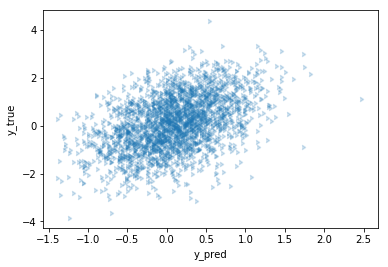

In [326]:
both = pd.concat([y,y_pred],axis=1)
both.plot.scatter(x='y_pred',y='y_true',alpha=0.2,marker=5)